In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hwk3-task1-spills.ipynb")

FileNotFoundError: [Errno 2] No such file or directory: 'hwk3-task1-spills.ipynb'

# Task 1: Visualizing oil spills in NY State

## Instructions

- First, update the following cell to have a link to *your* Homework 3 GitHub repository:

**UPDATE THIS LINK**
https://github.com/llumj/eds220-hwk3-Mull


- Review the [complete rubric for this task](https://docs.google.com/document/d/1Ce4EO3MEHW5uLks4x8BECWlkim2bcmxB4f8Qo4z26z8/edit?usp=sharing) before starting.

- **Meaningful commits should be made every time you finish a major step.** We'll check your repository and view the commit history.

- Comment mindfully in a way that enriches your code. Comments should follow best practices.

- **Do not update the top cell with the `otter` import**, this is used internally for grading.

- Delete all the comments initially included in this notebook (ex: `# Your code here`).


## About the data
In this task you will use two datsets:

### First dataset: oil spills data

The first dataset contains information about [spilling incidents in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
You can find extra information and metadata for this dataset in the `NYSDEC_SpillIncidents_Overview.pdf` and `NYSDEC_SpillIncidents_DataDictionary.pdf` documents available at the portal.

### Second dataset: TIGER shapefile

The second dataset is the [the 2023 Counties (and equivalent) TIGER shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341) from the Census Bureau. You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 


## 1. File management
a. Create a `data/` directory inside your `eds220-hwk3` directory. If you download any data, it should be transferred into this folder. 

b. Add the `data/` directory to your `.gitignore` file and push your changes. This is IMPORTANT: the datasets we'll be working with are large and they will most likely jam your `git` workflow if you try to push them. Your `data/` directory should not be in your GitHub repository.

## 2. Datasets description
Read the metadata for both datsets and write a description about each one. Indicate the date sources and date of access.


Shape files are digital representations of geographical features. In this case, we are working with county lines for the United States. 

The second file contains spills across new york state. It has has the start date, end date and types hazard that was spilled. 

## Complete Workflow

All records are from 2023, between January and October


<Axes: >

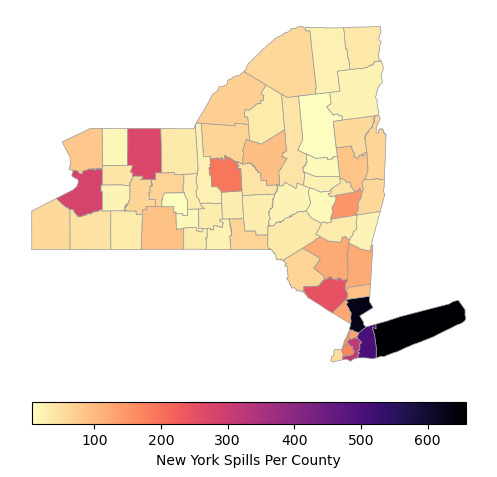

In [17]:
# Complete Workflow 

# Import library
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# Read in the data
spills = pd.read_csv("data/Spill_Incidents_20241107.csv")
us_counties = gpd.read_file("data/tl_2023_us_county")

# Check the head of each variable 
spills.head()
us_counties.head()

# Check data types 
spills.dtypes
us_counties.dtypes

# Find unique values in Material Family series
spills["Material Family"].unique()

# d. Find unique values in County series
spills['County'].unique()

# a. Simplify column names in spills variable
spills.columns = spills.columns.str.strip().str.lower().str.replace(' ', '_') 

# Covert date columns to date time 
spills.spill_date = pd.to_datetime(spills.spill_date)
spills.close_date = pd.to_datetime(spills.close_date)

# Check
spills.dtypes

# Select data for spills that took place between 2023/01/01 and 2023/10/31
petr_23 = spills.loc[(spills['spill_date'] >= '2023/01/01') & (spills['close_date'] <= '2023/10/31')].copy()
petr_23.head()

# extract all the years and months to new columns 
petr_23['spill_year'] = petr_23['spill_date'].dt.year
petr_23['spill_month'] = petr_23['spill_date'].dt.month
petr_23['close_year'] = petr_23['close_date'].dt.year
petr_23['close_month'] = petr_23['close_date'].dt.month

# Check columns
petr_23.head()

# Verify and print the messages using f-strings 
if (petr_23['spill_year'] == 2023).any() or not (petr_23['spill_month'].between(1, 10).all() and petr_23['close_month'].between(1, 10).all()): 
    print(f'All records are from 2023, between January and October') 
else: 
    print(f'Some records are outside of year 2023')

# Create assertion # out for running purpose
#assert (petr_23['material_family'] == 'Petroleum').all(), "Some records are not 'Petroleum'"

# Find the number of spills by county 
spills_per_county = petr_23.groupby('county').size().reset_index(name='n_spills')
spills_per_county

# Check the crs of us_counties
us_counties.crs

# Simplify us_counties 
us_counties.columns = us_counties.columns.str.lower()

# Check us_counties varible 
us_counties.tail()

# Filter statefp for 36, the corresponding code for New York state 
ny_counties = us_counties.loc[us_counties['statefp'] == '36']

# ny_counties.plot()

# Find county names in spills_per_county but not in ny_counties
diff_names_spills = np.setdiff1d(spills_per_county['county'], ny_counties['name'])
diff_names_spills

# Find county names in ny_counties but not in spills_per_county
diff_names_ny = np.setdiff1d(ny_counties['name'],spills_per_county['county'])
diff_names_ny

# Number of spills on Tuscarora Reservation
spills_per_county.loc[spills_per_county['county'] == 'Tuscarora Indian Reservation']

# Update column name 
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')

# Create assertion to check 
assert (spills_per_county['county'] == 'St. Lawrence').any(), 'Update Failed'

# Change column name before join
ny_counties = ny_counties.rename(columns = {'name' : 'county'})

# Inner join
ny_counties = pd.merge(ny_counties,
                       spills_per_county,
                       how='inner',
                       on='county')

# Add 1 to Niagara county
ny_counties.at[45, 'n_spills'] += 1

# Check 
ny_counties.loc[ny_counties['county'] == 'Niagara']

# Map
fig, ax = plt.subplots(figsize=(8, 6))

# Remove the axis for a cleaner map
ax.axis('off')

# Create choropleth map of communities
# Plot with refined color and edge style
ny_counties.plot(
    ax=ax,
    column='n_spills',
    cmap='magma_r',
    legend=True,
    edgecolor="0.6",
    linewidth=0.5,
    legend_kwds={
        "shrink": 0.7,
        "label": "New York Spills Per County",
        "orientation": "horizontal",
        "pad": 0.05
    }
)

# This map shows the number of spills by county in New York State. 
# The three counties with the most spills are Suffolk(657), Westchester(630), Nassau(503).

## 3. Import libraries

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## 4. Import data 
In the next cell:

- Import the NY spills data as a variable named `spills`. 
- Import the US counties data as a variable named `counties`.

If you are using file paths to access the data, these should be constructed using the `os` package.

In [3]:
spills = pd.read_csv("data/Spill_Incidents_20241107.csv")
us_counties = gpd.read_file("data/tl_2023_us_county")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds220-env/share/proj failed


## 5. Prepare spills data

This section refers to the `spills` dataframe. 
Check the outputs carefully, they will give you information you will need to use in the next exercises.

### 5.A. Exploration

In the next cells:

a. Check the dataframe's head.

b. Check the data types of the columns.

c. Check the unique values in the `material_family` column.

d. Check the unique values in the `county` column.

You can add other cells for preliminary data exploration.

In [ ]:
# Check the head of each variable 
spills.head()

In [ ]:
# Check data types 
spills.dtypes

In [ ]:
# Find unique values in Material Family series
spills["Material Family"].unique()

In [ ]:
# d. Find unique values in County series
spills['County'].unique()

<!-- BEGIN QUESTION -->

f. Use the next markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

<!-- END QUESTION -->

*Your answer here.*

I used head() to observe the first few rows of the data set. This allows me to see what values I am working with in each series. Looking up the data types allows me to see what type each value is. Looking at the unique values in material family I learned that there are 4 different categories. Looking at the unique values for county I noticed that there were values that were way longer than just a single county name. i.e. New Jersey - Region 3 (N)

### 5.B. Cleaning
a. Simplify column names as needed.

b. Update column data types as needed. If you're not sure if any data types are needed at this point, you may come back later to this cell.

In [ ]:
# a. Simplify column names in spills variable
spills.columns = spills.columns.str.strip().str.lower().str.replace(' ', '_')

# Check spills variable
print(spills.head())

In [ ]:
# Covert date columns to date time 
spills.spill_date = pd.to_datetime(spills.spill_date)
spills.close_date = pd.to_datetime(spills.close_date)

# Check
print(spills.dtypes)

### 5.C. Data selection

a. Select data about petroleum spills that took place between January 1st 2023, and October 31st 2023 (including both dates). Store it in a variable named `petr_23`. The data selection should occur in a single line. You may add cells as needed.

In [ ]:
# Select data for spills that took place between 2023/01/01 and 2023/10/31
petr_23 = spills.loc[(spills['spill_date'] >= '2023/01/01') & (spills['close_date'] <= '2023/10/31')].copy()
petr_23.head()

<!-- BEGIN QUESTION -->

b. Use `print()` and f-strings to print messages verifying that `petr_23` only has data for 2023 and from January through October.
HINT: [pandas.Series.dt.year](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.year.html) and [pandas.Series.dt.month](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html).

In [ ]:
# extract all the years and months to new columns 
petr_23['spill_year'] = petr_23['spill_date'].dt.year
petr_23['spill_month'] = petr_23['spill_date'].dt.month
petr_23['close_year'] = petr_23['close_date'].dt.year
petr_23['close_month'] = petr_23['close_date'].dt.month

petr_23.head()


            
# Verify and print the messages using f-strings 
if (petr_23['spill_year'] == 2023).any() or not (petr_23['spill_month'].between(1, 10).all() and petr_23['close_month'].between(1, 10).all()): 
    print(f'All records are from 2023, between January and October') 
else: 
    print(f'Some records are outside of year 2023')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

c. Write tests using `assert` to verify that `petr_23` only has data for petroleum spills.

In [ ]:
assert (petr_23['material_family'] == 'Petroleum').all(), "Some records are not 'Petroleum'"

<!-- END QUESTION -->

### 5.D. Data aggregation

Create new data frame named `spills_per_county` with the number of petroleum spills per county from January to October 2023 (i.e. use the `petr_23` dataframe).

The resulting `spills_per_county` dataframe must be as follows:

- Index: integer numbers starting from 0
- Data frame has two columns only:
    - Column one: county names, column name = `county`
    - Column two: number of petroleum spills per county in 2023, column name = `n_spills`

You may add cells if needed.


In [ ]:
# Your code here
spills_per_county = petr_23.groupby('county').size().reset_index(name='n_spills')
spills_per_county

## 6. Prepare counties data

This section refers to the `counties` geo-dataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### 6.A. Exploration

In the next cells:

a. Check the geo-dataframe's head.

b. Check the data types of the columns.

c. Check the geo-dataframe's CRS.

d. Plot the geo-dataframe.

You can add any other cells of preliminary data exploration.

In [ ]:
us_counties.head()

In [ ]:
# Check the data types of the columns 
us_counties.dtypes

In [ ]:
# Check the crs 
us_counties.crs

In [ ]:
# Plot the data frame 
us_counties.plot()

<!-- BEGIN QUESTION -->

f. Use the next markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

*Your answer here.*

<!-- END QUESTION -->

### 6.B. Cleaning

Simplify column names as needed.

In [ ]:
# Simplify us_counties 
us_counties.columns = us_counties.columns.str.lower()

# Check us_counties varible 
us_counties.tail()

### 6.C. Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them.

In [ ]:
# Filter statefp for 36, the corresponding code for New York state 
ny_counties = us_counties.loc[us_counties['statefp'] == '36']

ny_counties.plot()

## 7 Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### 7.A. Explore data

In the next cells:

a. Print the names of counties in `ny_counties`, without repetition.

b. Print the names of counties in `spills_per_county`, without repetition. Examine the differences in the outputs.


In [ ]:
# Print names in ny_counties without repetition
print(ny_counties['name'].unique())

In [ ]:
# Print names in spills_per_county without repetition
print(spills_per_county['county'].unique())





c. Which are the county names that are in `spills_per_county`, but not in `ny_counties`? Your answer should be a list of strings
HINT: You can use the `numpy` function [`setdiff1d()`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html), pay attention to the example in the documentation. Store your answer in the `diff_names` variable. 



In [ ]:
# Find county names in spills_per_county but not in ny_counties
diff_names_spills = np.setdiff1d(spills_per_county['county'], ny_counties['name'])
diff_names_spills


d. Which are the county names that are in `ny_counties`, but not in `spills_per_county`? Your answer should be a list of strings.


In [ ]:
# Find county names in ny_counties but not in spills_per_county
diff_names_ny = np.setdiff1d(ny_counties['name'],spills_per_county['county'])
diff_names_ny




e. What is the number of spills in 'Tuscarora Indian Reservation'?


In [ ]:
# Number of spills on Tuscarora Reservation
print(spills_per_county.loc[spills_per_county['county'] == 'Tuscarora Indian Reservation'])

### 7.B. Data updates

In the next cell, update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame and use an `assert` statement to verify that the update was successful.

You may add cells if needed.

In [ ]:
# Update column name 
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')

assert (spills_per_county['county'] == 'St. Lawrence').any(), 'Update Failed'

### 7.C. Merge

In the following cells:

a. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 

b. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.


In [ ]:
ny_counties = ny_counties.rename(columns = {'name' : 'county'})

In [ ]:
# Inner join
ny_counties = pd.merge(ny_counties,
                       spills_per_county,
                       how='inner',
                       on='county')


From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

c. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. Add the cells you need to make this update **and** verify that the dataframe was updated.

In [ ]:
# Add 1 to Niagara county
ny_counties.at[45, 'n_spills'] += 1

In [ ]:
# Check 
print(ny_counties.loc[ny_counties['county'] == 'Niagara'])

<!-- BEGIN QUESTION -->

## 8. Map
a. Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should be polished and have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an [annotation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html) with the data source (New York State Department of Environmental Conservation) and date of access.



<Axes: >

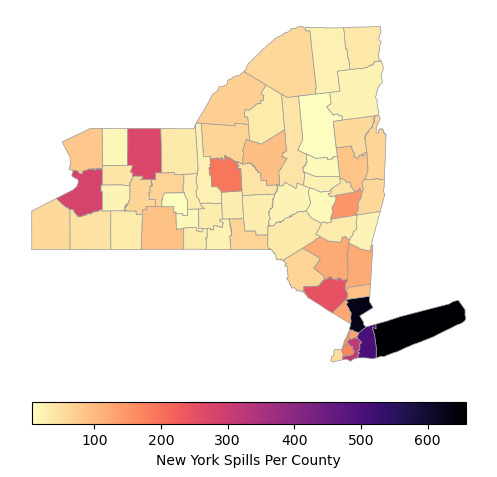

In [16]:
# Map
fig, ax = plt.subplots(figsize=(8, 6))

# Remove the axis for a cleaner map
ax.axis('off')

# Create choropleth map of communities
# Plot with refined color and edge style
ny_counties.plot(
    ax=ax,
    column='n_spills',
    cmap='magma_r',
    legend=True,
    edgecolor="0.6",
    linewidth=0.5,
    legend_kwds={
        "shrink": 0.7,
        "label": "New York Spills Per County",
        "orientation": "horizontal",
        "pad": 0.05
    }
)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Write a figure description for the map, including tha names of the top 3 counties with the most petroleum spills. If you need to do additional data analysis to include relevant information from the data, you may include additional code cells here.

This map shows the number of spills by county in New York State. The three counties with the most spills are Suffolk(657), Westchester(630), Nassau(503).

In [ ]:
ny_counties = ny_counties.sort_values(by= 'n_spills', ascending=False)
ny_counties.head(3)